In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
#import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

#cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\abdullah\projects\Brain Tumor\Brain-Tumor-Image-Classification-Project\data\Brain Tumor Classification (MRI)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names, device)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'] cuda:0


tensor([3, 0, 0, 1])


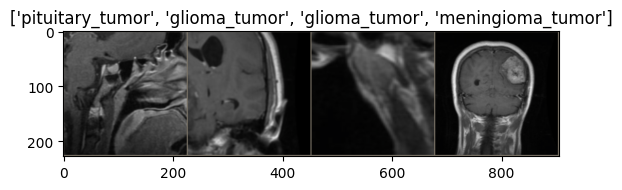

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
model_ft = models.resnet101(weights='DEFAULT')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs,  len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to C:\Users\abdullah/.cache\torch\hub\checkpoints\resnet101-cd907fc2.pth
100.0%


In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8789 Acc: 0.6390
val Loss: 2.7213 Acc: 0.5381

Epoch 1/24
----------
train Loss: 0.5213 Acc: 0.8056
val Loss: 1.1913 Acc: 0.6599

Epoch 2/24
----------
train Loss: 0.4068 Acc: 0.8474
val Loss: 1.1031 Acc: 0.7335

Epoch 3/24
----------
train Loss: 0.3208 Acc: 0.8819
val Loss: 1.4865 Acc: 0.6701

Epoch 4/24
----------
train Loss: 0.2844 Acc: 0.8990
val Loss: 1.2765 Acc: 0.7589

Epoch 5/24
----------
train Loss: 0.2624 Acc: 0.9028
val Loss: 1.0924 Acc: 0.7817

Epoch 6/24
----------
train Loss: 0.2303 Acc: 0.9091
val Loss: 1.0055 Acc: 0.7716

Epoch 7/24
----------
train Loss: 0.2101 Acc: 0.9254
val Loss: 2.1021 Acc: 0.6574

Epoch 8/24
----------
train Loss: 0.1778 Acc: 0.9362
val Loss: 1.1524 Acc: 0.7716

Epoch 9/24
----------
train Loss: 0.1802 Acc: 0.9300
val Loss: 1.4057 Acc: 0.7335

Epoch 10/24
----------
train Loss: 0.1821 Acc: 0.9268
val Loss: 1.5393 Acc: 0.6878

Epoch 11/24
----------
train Loss: 0.1790 Acc: 0.9373
val Loss: 1.1215 Acc: 0.7919

Ep

NameError: name 'imshow' is not defined

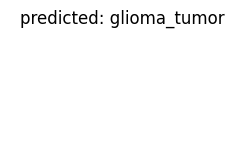

In [7]:
visualize_model(model_ft)

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs,  len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9791 Acc: 0.6345
val Loss: 1.7179 Acc: 0.5990

Epoch 1/24
----------
train Loss: 0.7328 Acc: 0.7436
val Loss: 1.8978 Acc: 0.5838

Epoch 2/24
----------
train Loss: 0.6085 Acc: 0.7815
val Loss: 1.2428 Acc: 0.7081

Epoch 3/24
----------
train Loss: 0.5708 Acc: 0.8049
val Loss: 1.4477 Acc: 0.7208

Epoch 4/24
----------
train Loss: 0.5202 Acc: 0.8157
val Loss: 1.2688 Acc: 0.6675

Epoch 5/24
----------
train Loss: 0.4761 Acc: 0.8355
val Loss: 1.2862 Acc: 0.7665

Epoch 6/24
----------
train Loss: 0.4567 Acc: 0.8488
val Loss: 1.3300 Acc: 0.7893

Epoch 7/24
----------
train Loss: 0.3210 Acc: 0.8850
val Loss: 1.2830 Acc: 0.7589

Epoch 8/24
----------
train Loss: 0.2844 Acc: 0.9042
val Loss: 1.4350 Acc: 0.7589

Epoch 9/24
----------
train Loss: 0.2951 Acc: 0.8958
val Loss: 1.4235 Acc: 0.7335

Epoch 10/24
----------
train Loss: 0.2716 Acc: 0.9084
val Loss: 1.0941 Acc: 0.7640

Epoch 11/24
----------
train Loss: 0.2449 Acc: 0.9230
val Loss: 1.0870 Acc: 0.7970

Ep

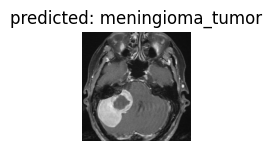

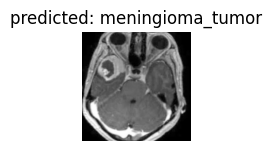

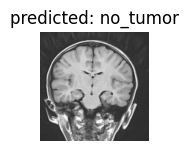

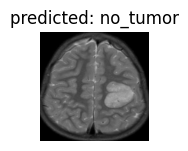

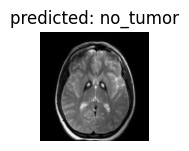

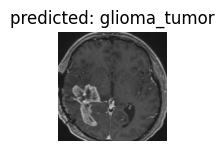

In [8]:
visualize_model(model_ft)

In [6]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [7]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1331 Acc: 0.5310
val Loss: 1.4490 Acc: 0.4721

Epoch 1/24
----------
train Loss: 0.9715 Acc: 0.6150
val Loss: 1.4806 Acc: 0.5152

Epoch 2/24
----------
train Loss: 0.9223 Acc: 0.6540
val Loss: 1.3670 Acc: 0.5152

Epoch 3/24
----------
train Loss: 0.9304 Acc: 0.6484
val Loss: 1.8736 Acc: 0.4822

Epoch 4/24
----------
train Loss: 0.9522 Acc: 0.6383
val Loss: 1.5355 Acc: 0.5051

Epoch 5/24
----------
train Loss: 0.9409 Acc: 0.6456
val Loss: 1.3823 Acc: 0.6015

Epoch 6/24
----------
train Loss: 0.9144 Acc: 0.6516
val Loss: 2.1866 Acc: 0.4822

Epoch 7/24
----------
train Loss: 0.7661 Acc: 0.7052
val Loss: 1.4073 Acc: 0.5558

Epoch 8/24
----------
train Loss: 0.7929 Acc: 0.6843
val Loss: 1.4099 Acc: 0.5381

Epoch 9/24
----------
train Loss: 0.7739 Acc: 0.6895
val Loss: 1.3972 Acc: 0.5431

Epoch 10/24
----------
train Loss: 0.7390 Acc: 0.7049
val Loss: 1.4951 Acc: 0.5812

Epoch 11/24
----------
train Loss: 0.7395 Acc: 0.7063
val Loss: 1.8095 Acc: 0.5152

Ep

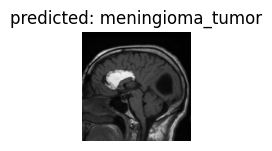

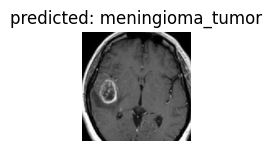

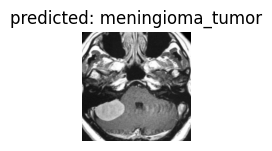

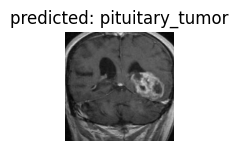

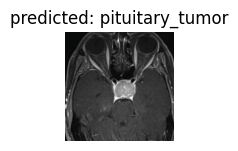

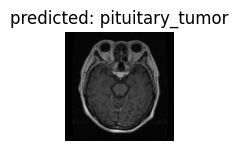

In [9]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [8]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

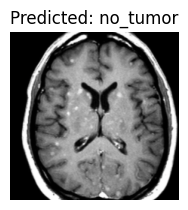

In [10]:
visualize_model_predictions(
    model_conv,
    img_path=r'C:\Users\abdullah\projects\Brain Tumor\Brain-Tumor-Image-Classification-Project\data\Brain Tumor Classification (MRI)\train\no_tumor\4.jpg'
)

plt.ioff()
plt.show()

In [1]:
import evaluate

c:\Users\abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
